## **IMPORTS**

In [11]:
#IMPORTS
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [12]:
fN = 'CSE483 Sp24 Project Test Cases'
img_array = [fN+'/01-Getting-started.png',fN+'/02-Matsawar-3edel-ya3am.png', fN+'/03-Leffy-bina-ya-donya.png']
img_address = img_array[1]

#### **Importing image and binarizing (making it either 0 or 255)**

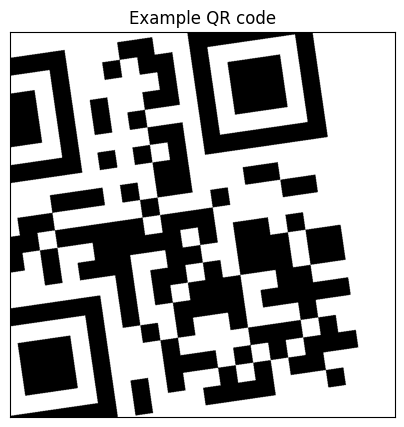

In [13]:

img = cv2.imread(img_address, cv2.IMREAD_GRAYSCALE)
# cv2.imshow("img", img)
_, img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
fig = plt.figure(figsize=(5, 5))
plt.xticks([], [])
plt.yticks([], [])
plt.title('Example QR code')
plt.imshow(img, cmap='gray')
# detecting_area_of_qr(img)

In [ ]:
# # Detect edges or contours to find the orientation of the QR code
# # Example: edge detection using Canny
# edges = cv2.Canny(img, 50, 150)
# # Find contours and fit a rotated bounding box
# contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# rect = cv2.minAreaRect(contours[0])
# angle = rect[2]
# # Rotate the image
# (h, w) = img.shape[:2]
# center = (w // 2, h // 2)
# M = cv2.getRotationMatrix2D(center, angle, 1.0)
# img = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
# # Now you can use the rotated_img for further processing (thresholding, finding boundaries, etc.)
# plt.imshow(img, cmap='gray')


## Use quiet zone to detect code area
Simply go through white rows and columns until you find the first black pixel from the left, from the right, from the top, and from the bottom.

In [ ]:
start_row = -1
start_col = -1
end_row = -1
end_col = -1

for row_index, row in enumerate(img):
    for pixel in row:
        if pixel != 255:
            start_row = row_index
            break
    if start_row != -1:
        break

for row_index, row in enumerate(img[::-1]):
    for pixel in row:
        if pixel != 255:
            end_row = img.shape[0] - row_index
            break
    if end_row != -1:
        break

for col_index, col in enumerate(cv2.transpose(img)):
    for pixel in col:
        if pixel != 255:
            start_col = col_index
            break
    if start_col != -1:
        break

for col_index, col in enumerate(cv2.transpose(img)[::-1]):
    for pixel in col:
        if pixel != 255:
            end_col = img.shape[1] - col_index
            break
    if end_col != -1:
        break

print("start row: ", start_row, ", end row: ", end_row, ", start col: ", start_col, ", end col: ", end_col)
#get_qr_without_quiet_zone(img, start_row, end_row, start_col, end_col)

In [ ]:
qr_no_quiet_zone = img[start_row:end_row, start_col:end_col]
fig = plt.figure(figsize=(5, 5))
plt.xticks([], [])
plt.yticks([], [])
fig.get_axes()[0].spines[:].set_color('red')
fig.get_axes()[0].spines[:].set_linewidth(40)
fig.get_axes()[0].spines[:].set_position(("outward", 20))
plt.title('QR code without quiet zone', y=1.15, color='red')
plt.imshow(qr_no_quiet_zone, cmap='gray')
#determine_grid_size(qr_no_quiet_zone)

## Use locator boxes to determine grid size
Since we know that the topleft pixel should be the border of the locator box, and that its size should be 7×7, we can determine the grid cell size by dividing its size in pixels by 7. How to get its size? It is a constant black row of pixels followed by one white cell. A simple for loop can get it done.

In [ ]:
size = 0
for pixel in qr_no_quiet_zone[0]:
    if (pixel != 0): break
    size += 1
grid_cell_size = round(size / 7)
grid_cells_num = round(qr_no_quiet_zone.shape[0] / grid_cell_size)
print(qr_no_quiet_zone.shape)
# ...into grid cells
qr_cells = qr_no_quiet_zone.reshape((
    grid_cells_num,
    grid_cell_size,
    grid_cells_num,
    grid_cell_size,
)).swapaxes(1, 2)
print(qr_cells.shape)
_, axes = plt.subplots(grid_cells_num, grid_cells_num, figsize=(5, 5))
for i, row in enumerate(axes):
    for j, col in enumerate(row):
        col.imshow(qr_cells[i][j], cmap="gray", vmin=0, vmax=255)
        col.get_xaxis().set_visible(False)
        col.get_yaxis().set_visible(False)
        col.spines[:].set_color('red')
# converting_grid_into_numbers(grid_cells_num, qr_cells)

## Convert grid tiles to numeric values

In [ ]:
qr_cells_numeric = np.ndarray((grid_cells_num, grid_cells_num), dtype=np.uint8)
for i, row in enumerate(qr_cells):
    for j, cell in enumerate(row):
        qr_cells_numeric[i, j] = (np.median(cell) // 255)
print(qr_cells_numeric)
plt.show()

### Error correction level

In [ ]:
print(qr_cells_numeric[8])

In [ ]:
# The first two bits determine the error correction level
# Level L (Low)         [11]	7%  of data bytes can be restored.
# Level M (Medium)      [10]	15% of data bytes can be restored.
# Level Q (Quartile)    [01]	25% of data bytes can be restored.
# Level H (High)        [00]	30% of data bytes can be restored.
ecl = [int(not (c)) for c in qr_cells_numeric[8, 0:2]]
# Why "not"? Because the standard uses '1's for black and '0's for white
#
# "A dark module is a binary one and a light module is a binary zero."
#  - ISO/IEC 18004:2000(E)
#
# In image processing, we use them the other way.. Hence the inversion
print(ecl)
# mask_pattern(qr_cells_numeric)

### Mask pattern

In [ ]:
# Dictionary of all masks and their equivalent formulae
MASKS = {
    "000": lambda i, j: (i * j) % 2 + (i * j) % 3 == 0,
    "001": lambda i, j: (i / 2 + j / 3) % 2 == 0,
    "010": lambda i, j: ((i * j) % 3 + i + j) % 2 == 0,
    "011": lambda i, j: ((i * j) % 3 + i * j) % 2 == 0,
    "100": lambda i, j: i % 2 == 0,
    "101": lambda i, j: (i + j) % 2 == 0,
    "110": lambda i, j: (i + j) % 3 == 0,
    "111": lambda i, j: j % 3 == 0,
}

# Same row as above, the three cells after the ecl cells (converted to a string)
mask = [int(not (c)) for c in qr_cells_numeric[8, 2:5]]
mask_str = ''.join([str(c) for c in mask])
print(mask_str)
# format_error_correction(qr_cells_numeric)
# plt.show()

### Format error correction

In [ ]:
# Same row as above, but we want cells #5 and #7 (#6 is always set to 0),
#  followed by column #8 from cell #0 in it to cell #7 (and skipping #6)
fec = []
fec.append(qr_cells_numeric[8, 5])
fec.append(qr_cells_numeric[8, 7])
fec.extend(qr_cells_numeric[0:6, 8])
fec.extend(qr_cells_numeric[7:9, 8])
fec = [int(not (c)) for c in fec]
print(fec)

In [ ]:
# So in total we have the following 15 bits of format info from our QR code
print(ecl, mask, fec)

In [ ]:
# Let's cross-check with our example
_, axes = plt.subplots(grid_cells_num, grid_cells_num, figsize=(5, 5))
for i, row in enumerate(axes):
    for j, col in enumerate(row):

        col.get_xaxis().set_visible(False)
        col.get_yaxis().set_visible(False)
        if (i == 8 and j <= 8) or (i <= 8 and j == 8):
            if (i != 6) and (j != 6):
                col.imshow(qr_cells[i][j], cmap="gray", vmin=0, vmax=255)
                col.spines[:].set_color('red')
                continue
        col.imshow(qr_cells[i][j], cmap="gray", vmin=-1275, vmax=510)
    # print(ecl, mask, fec)

In [ ]:
# However..... You need to XOR that with the "format mask": 101010000010010
ecl[0] ^= 1
mask[0] ^= 1
mask[2] ^= 1
fec[5] ^= 1
fec[8] ^= 1

# And now we print...
print(ecl, mask, fec)

## Data extraction


In [ ]:
# Before we proceed, let's write a function for masking to make our lives easier
UP, UP_ENC, DOWN, CW, CCW = range(5)  # A rather old-fashioned pythonic "Enum"

def apply_mask(data_start_i, data_start_j, direction):
    '''
    data_start_i/j represent the first cell's coords in its respective direction
    direction is the masking direction, up(-enc)/down/clockwise/anti-clockwise
    '''
    result = []
    row_offsets = []
    col_offsets = []
    if (direction in [UP, UP_ENC]):
        row_offsets = [0,  0, -1, -1, -2, -2, -3, -3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction == DOWN):
        row_offsets = [0,  0,  1,  1,  2,  2,  3,  3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction == CW):
        row_offsets = [0,  0,  1,  1,  1,  1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]
    if (direction == CCW):
        row_offsets = [0,  0, -1, -1, -1, -1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]

    for i, j in zip(row_offsets, col_offsets):
        cell = qr_cells_numeric[data_start_i+i, data_start_j+j]
        result.append(int(cell if MASKS[mask_str](data_start_i+i, data_start_j+j) else not cell))

    return result[:4] if direction == UP_ENC else result

### Data encoding

In [ ]:
enc = apply_mask(grid_cells_num-1, grid_cells_num-1, UP_ENC)
print(enc)

### Data length

In [ ]:
len = apply_mask(grid_cells_num-3, grid_cells_num-1, UP)
print(len)

### Data extraction

In [ ]:
data_starting_indices = [
    [grid_cells_num-7, grid_cells_num-1, UP],
    [grid_cells_num-11, grid_cells_num-1, CCW],
    [grid_cells_num-10, grid_cells_num-3, DOWN],
    [grid_cells_num-6, grid_cells_num-3, DOWN],
    [grid_cells_num-2, grid_cells_num-3, CW],
    [grid_cells_num-3, grid_cells_num-5, UP],
    [grid_cells_num-7, grid_cells_num-5, UP],
    [grid_cells_num-11, grid_cells_num-5, CCW],
    [grid_cells_num-10, grid_cells_num-7, DOWN],
    [grid_cells_num-6, grid_cells_num-7, DOWN],
    [grid_cells_num-2, grid_cells_num-7, CW],
    [grid_cells_num-3, grid_cells_num-9, UP],
    [grid_cells_num-7, grid_cells_num-9, UP],
    [grid_cells_num-11, grid_cells_num-9, UP],
    [grid_cells_num-16, grid_cells_num-9, UP],
    [grid_cells_num-20, grid_cells_num-9, CCW],
    [grid_cells_num-19, grid_cells_num-11, DOWN],
    [grid_cells_num-14, grid_cells_num-11, DOWN],
    [grid_cells_num-10, grid_cells_num-11, DOWN],
    [grid_cells_num-6, grid_cells_num-11, DOWN],
    # Hmm..? I actually don't know how to proceed now lol
]

ans = ''
for a, b, d in data_starting_indices:
    bits = apply_mask(a, b, d)
    bit_string = ''.join([str(bit) for bit in bits])
    if bit_string[:4] == "0000":
        print(f'{bit_string[:4]} = 0 (NULL TERMINATOR)')
        break
    ans += chr(int(bit_string, 2)) # converts to binary to int, then to ASCII
    print(f'{bit_string} = {ans[-1]}')

print(f'\nDecoded string: {ans}')